In [217]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from scipy.integrate import quad, solve_ivp, odeint
from scipy.optimize import root_scalar
from scipy.interpolate import CubicSpline
from numpy import pi, sqrt, exp, arcsinh, log as ln

In [218]:
# c = 2.998e8
# G = 6.67e-11
# hbar = 1.055e-34


# m = 1.67e-27
# u0 = 1 / (8 * pi**2) * m**4 * (c**5 / hbar**3)

# MO = 1.989e30

# m0 = c**4 / sqrt(4 * pi * u0*G**3)
# r0 = G * m0 / c**2


# print(u0)
# print(m0)
# print(m0/MO)
# print(r0)

In [284]:
x0 = 1e-2

def p_para(x): 
    if x<x0:return 8/5 * x**5
    else: return (2*x**3 - 3*x) * sqrt(x**2 + 1) + 3 * arcsinh(x)

def u_para(x):
    if x<x0: return 8/3*x**3 + 4/5*x**5
    else: return (2*x**3 + x) * sqrt(x**2 + 1) - arcsinh(x)

p_para = np.vectorize(p_para)
u_para = np.vectorize(u_para)

In [286]:
X = 10**np.linspace(-5, 5, 100)
P = p_para(x)
    

In [288]:
def u(p0, x0=1):
    if p0<0: return 0
    f = lambda x: p_para(x) - p0
    x = root_scalar(f, bracket=(0, 1e10)).root
    u = u_para(x)
    assert u>=0
    return u

u = np.vectorize(u)


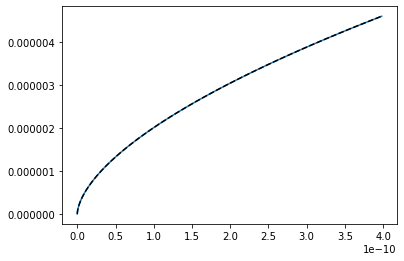

In [293]:
x = np.linspace(0, 1.2e-2, 100)
px = p_para(x)
ux = u_para(x)
# print(p)
# plt.plot(x, p)
# plt.plot(x, ux)
plt.plot(px, ux)
plt.plot(px, u(px), "k--") 


In [295]:
def dmdr(r, y, args):
    p, m = y
    return u(p) * r**2

def dpdr(r, y, args):
    p, m = y
    if r<1e-10:
        p0 = args
        u0 = u(p0)
        return - r * (p + u0) * (p + u0) / (1 - 2 * u0 * r )
    else:
        Dp = - (p + u(p)) * (p * r**3 + m) /  (1 - 2 * m/r ) / r**2
        return Dp

In [296]:
def f(r, y, args):
    return dpdr(r, y, args), dmdr(r, y, args)

def stop(r, y, args):
    p, m = y
    return p
stop.terminal = True


In [297]:
def sim(p0 = 0.01):
    return solve_ivp(f, (0, 1e10), (p0, 0), args=(p0,), events=stop, dense_output=True)

In [298]:
s = sim(1)

In [299]:
s

  message: 'A termination event occurred.'
     nfev: 122
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f0d31c416a0>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.00856995e-01, 2.02259270e-01, 3.42937074e-01, 5.23246754e-01,
       7.38145862e-01, 8.92112883e-01, 1.04607990e+00, 1.19886650e+00,
       1.35165310e+00, 1.48974911e+00, 1.58243948e+00, 1.67512986e+00,
       1.76059466e+00, 1.79066920e+00])
 t_events: [array([1.7906692])]
        y: array([[1.00000000e+00, 9.99999962e-01, 9.99995377e-01, 9.99529376e-01,
        9.61906251e-01, 8.55479667e-01, 6.39265835e-01, 3.56124251e-01,
        1.34115565e-01, 5.74046661e-02, 2.22033418e-02, 7.76166301e-03,
        2.29210994e-03, 5.43550036e-04, 1.46959439e-04, 3.43953119e-05,
        6.05332400e-06, 1.01643954e-20],
       [0.00000000e+00, 9.63726537e-13, 1.28271746e-09, 1.31775248e-06,
        9.72296421e-04, 7.4557

array([1.00000000e+00, 9.99999962e-01, 9.99995377e-01, 9.99529376e-01,
       9.61906251e-01, 8.55479667e-01, 6.39265835e-01, 3.56124251e-01,
       1.34115565e-01, 5.74046661e-02, 2.22033418e-02, 7.76166301e-03,
       2.29210994e-03, 5.43550036e-04, 1.46959439e-04, 3.43953119e-05,
       6.05332400e-06])

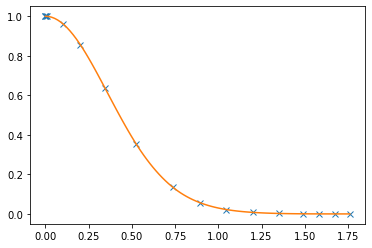

In [300]:
n = -1
r = s.t[:n]
p = s.y[0][:n]

spline = CubicSpline(r, p)
plt.plot(r, p, "x")
r1 = np.linspace(r[0], r[-1], 100)
plt.plot(r1, spline(r1))


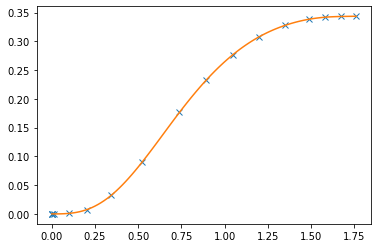

In [319]:
m = s.y[1][:n]
spline = CubicSpline(r, m)
 
plt.plot(r, m, "x")
plt.plot(r1, spline(r1))

In [348]:
def sim_many():
    N = 100
    p0s = 10**np.linspace(-4, 2, N)

    M = np.zeros(N)
    R = np.zeros(N)

    for i, p0 in enumerate(p0s):
        s = solve_ivp(f, (0, 10), (p0, 0), args=(p0,), events=stop, method='DOP853')
        rs = s.t
        ps, ms = s.y
        M[i] = ms[-1]
        R[i] = rs[-1]

    return R, M


In [349]:
R, M = sim_many()

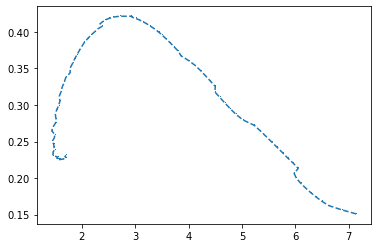

In [350]:
plt.plot(R, M, "--,")

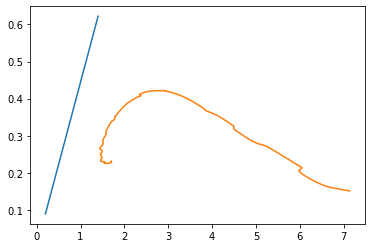

In [352]:
Rs = np.linspace(0.2, 1.4, 100)
plt.plot(Rs,  4 / 9 * Rs)
plt.plot(R, M)